# Actividad 3 Diego Fluxá

Comenzaremos por importar las librerias necesarias para trabajar nuestros datos

In [1]:
import sqlite3, csv
import pandas as pd
import matplotlib.pyplot as plt

Ahora, crearemos una nueva tabla a partir de nuestro archivo "presupuesto_2019.csv" para relacionarlo con las tablas dentro de nuestra base de datos

In [2]:
con = sqlite3.connect("municipios.db")
cur = con.cursor()
cur.execute("DROP TABLE IF EXISTS Presupuestos;")
cur.execute("CREATE TABLE Presupuestos (id int, municipio varchar(255), presupuesto int);") # use your column names here

with open('presupuesto_2019.csv','r') as fin:
    dr = csv.DictReader(fin)
    to_db = [(i['CODIGO'], i['MUNICIPIO'], i['Presupuesto']) for i in dr]

cur.executemany("INSERT INTO Presupuestos VALUES (?, ?, ?);", to_db)

Ahora, revisaremos si se creó la tabla correctamente al imprimir las primeras 50 filas

In [3]:
cur.execute("SELECT * FROM Presupuestos;")
for i in range(50):
    print(cur.fetchone())

(1101, 'IQUIQUE', 59072234)
(1107, 'ALTO HOSPICIO', 13984404)
(1401, 'POZO ALMONTE', 7613962)
(1402, 'CAMIÑA', 1584008)
(1403, 'COLCHANE', 2500000)
(1404, 'HUARA', 3950000)
(1405, 'PICA', 5887820)
(2101, 'ANTOFAGASTA', 100635302)
(2102, 'MEJILLONES', 9379132)
(2103, 'SIERRA GORDA', 8184166)
(2104, 'TALTAL', 7055871)
(2201, 'CALAMA', 46212092)
(2202, 'OLLAGÜE', 2663357)
(2203, 'SAN PEDRO DE ATACAMA', 7294095)
(2301, 'TOCOPILLA', 5402461)
(2302, 'MARÍA ELENA', 4283361)
(3101, 'COPIAPÓ', 29543912)
(3102, 'CALDERA', 9127075)
(3103, 'TIERRA AMARILLA', 6147200)
(3201, 'CHAÑARAL', 4435860)
(3202, 'DIEGO DE ALMAGRO', 6284308)
(3301, 'VALLENAR', 9106767)
(3302, 'ALTO DEL CARMEN', 3318171)
(3303, 'FREIRINA', 2998977)
(3304, 'HUASCO', 3946468)
(4101, 'LA SERENA', 59222000)
(4102, 'COQUIMBO', 56819394)
(4103, 'ANDACOLLO', 3586345)
(4104, 'LA HIGUERA', 4090360)
(4105, 'PAIGUANO', 4780000)
(4106, 'VICUÑA', 8069308)
(4201, 'ILLAPEL', 6299700)
(4202, 'CANELA', 3000000)
(4203, 'LOS VILOS', 7103931)
(42

A continuación, utilizaremos panda para crear un dataframe a partir de una query de sql que nos entregue los datos que nos son de interés

In [4]:
query = '''
SELECT c.id, p.presupuesto, av.metros_plaza, av.metros_parque FROM Comuna AS c, Presupuestos AS p, Areas_Verdes AS av 
WHERE c.id = p.id AND c.id = av.id_comuna AND av.metros_plaza != '' AND av.metros_parque != '' AND p.presupuesto != 'No Recepcionado';'''
df = pd.read_sql_query(query, con)
df = df.dropna(how='any',axis=0) #En caso de que sigan existiendo filas con valores nulos
df

,id,presupuesto,metros_plaza,metros_parque
0,1101,59072234,58460,94824
1,1107,13984404,130316,0
2,1402,1584008,4050,0
3,1404,3950000,2300,0
4,1405,5887820,12925,20749
...,...,...,...,...
307,16301,10459701,168800,82226
308,16302,5001190,21282,0
309,16303,3386698,21925,0
310,16304,1798500,9500,0


In [5]:
con.commit()
con.close()

## 2.1. Correlación entre áreas verdes y presupuesto

### 1. Crea un gráfico de puntos para visualizar la correlación entre el presupuesto de las comunas y la superficie en metros cuadrados de plazas con la que cuentan esas comunas. Entrega el coeficiente de correlación entre esos dos campos.

Para esto comenzaremos filtrando las columnas de nuestro dataframe

In [6]:
presupuesto = df[['presupuesto']]
plaza = df[['metros_plaza']]
parque = df[['metros_parque']]

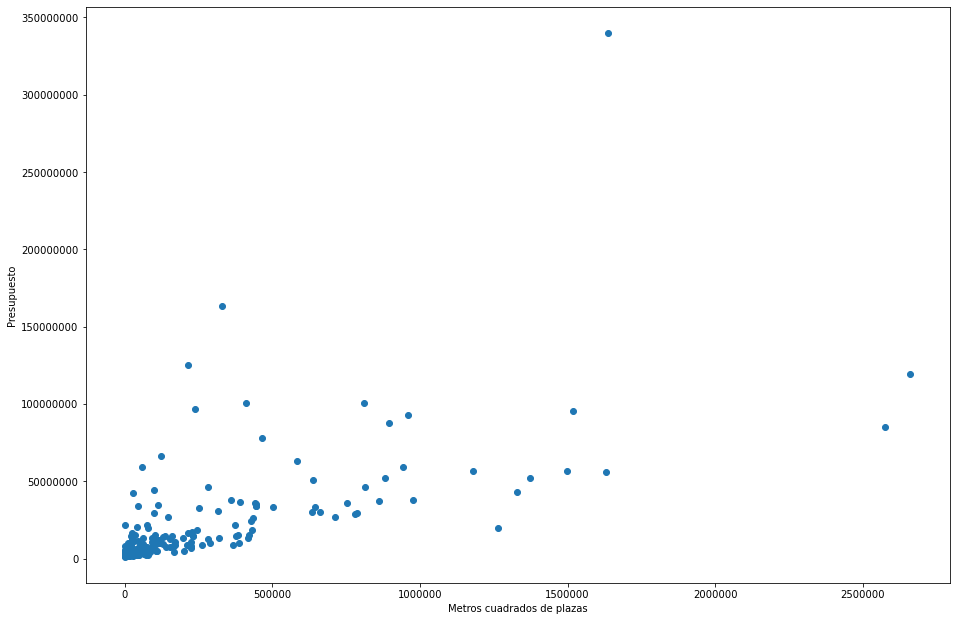

In [7]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
plt.scatter(plaza, presupuesto)
ax.set_xlabel('Metros cuadrados de plazas')
ax.set_ylabel('Presupuesto')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [8]:
df_corr = pd.merge(presupuesto, plaza, left_index=True, right_index=True)
corr_matrix = df.corr()
corr_matrix['presupuesto'].sort_values(ascending=False)

presupuesto      1.000000
metros_plaza     0.665585
id               0.135770
metros_parque   -0.008110
Name: presupuesto, dtype: float64

Finalmente, obtenemos que la correlación entre el presupuesto y los metros cuadrados plazas es de 0.665585

### 2. . Crea un gráfico de puntos para visualizar la correlación entre el presupuesto de las comunas y la superficie en metros cuadrados total, es decir, sumando plazas con áreas verdes, con la que cuentan esas comunas. Entrega el coeficiente de correlación entre esos dos campos.

Comenzamos creando una nueva columna que corresponderá a la suma entre los metros cuadrados de plazas y de parques

In [9]:
suma = df['metros_plaza'] + df['metros_parque']
suma

0      153284
1      130316
2        4050
3        2300
4       33674
        ...  
307    251026
308     21282
309     21925
310      9500
311     40480
Length: 312, dtype: int64

Agregamos nuestra nueva columna al dataframe

In [10]:
df['metros_ambos'] = suma
ambos = df[['metros_ambos']]
ambos

,metros_ambos
0,153284
1,130316
2,4050
3,2300
4,33674
...,...
307,251026
308,21282
309,21925
310,9500


Nuestra nueva tabla queda como

In [11]:
print(df.sort_values(by=['id']).to_string()) #Se puede cambiar el 'id' por otra columna para ordenarla con respecto a esa

        id  presupuesto  metros_plaza  metros_parque  metros_ambos
0     1101     59072234         58460          94824        153284
1     1107     13984404        130316              0        130316
2     1402      1584008          4050              0          4050
3     1404      3950000          2300              0          2300
4     1405      5887820         12925          20749         33674
5     2101    100635302        409807         269533        679340
6     2103      8184166          8287          35608         43895
7     2201     46212092        283236         180901        464137
8     2202      2663357          2500              0          2500
9     2302      4283361          6410              0          6410
10    3102      9127075        170367          22206        192573
11    3103      6147200          5000          16000         21000
12    3201      4435860         13878            569         14447
13    3202      6284308         28600          57000         8

Ahora, utilizamos matplotlib para graficar un gráfico de puntos con el fin de visualizar la correlación entre el presupuesto de las comunas y la superficie en metros cuadrados total

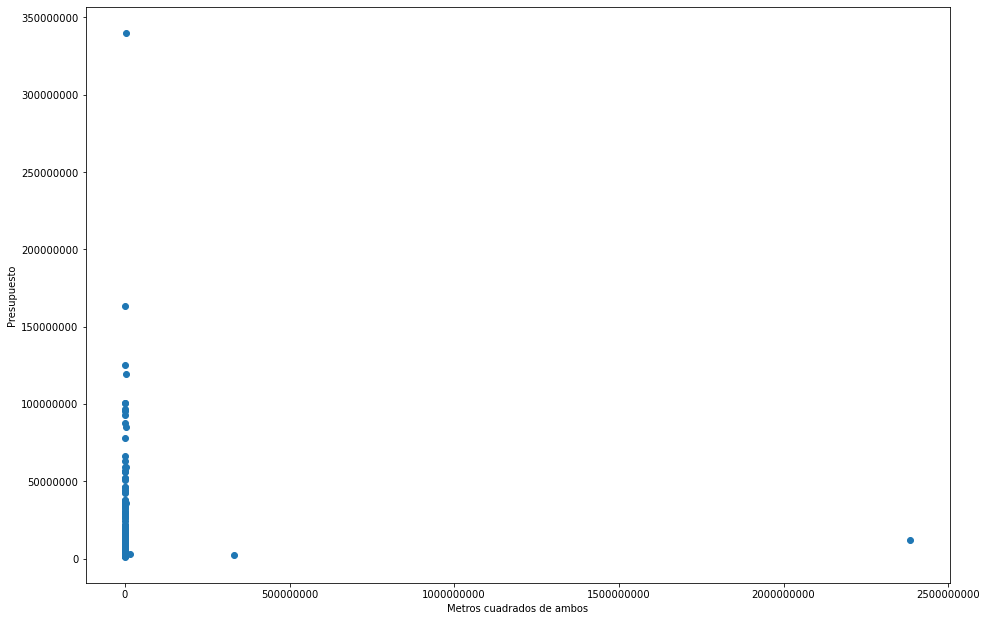

In [12]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,2])
ax.scatter(ambos, presupuesto)
ax.set_xlabel('Metros cuadrados de ambos')
ax.set_ylabel('Presupuesto')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()

In [13]:
df_corr = pd.merge(presupuesto, ambos, left_index=True, right_index=True)
corr_matrix = df_corr.corr()
corr_matrix['presupuesto'].sort_values(ascending=False)

presupuesto     1.000000
metros_ambos   -0.006414
Name: presupuesto, dtype: float64

Finalmente, obtenemos que la correlación entre el presupuesto y los metros cuadrados totales es de -0.006414

### 3. En base a esos dos experimentos, argumenta qué campo es mejor para ser utilizado en una regresión: la superficie de plazas o la superficie de plazas sumadas con parques.

Dado que la superficie de plazas (0.665585) posee un coeficiente de correlación más cercano a 1, será mejor que la superficie de plazas sumadas con parques (-0.006414) para ser utilizado en una regresión lineal.

A continuación se puede ver la correlación entre el presupuesto y todas las otras columnas de nuestra tabla

In [14]:
corr_matrix = df.corr()
corr_matrix['presupuesto'].sort_values(ascending=False)

presupuesto      1.000000
metros_plaza     0.665585
id               0.135770
metros_ambos    -0.006414
metros_parque   -0.008110
Name: presupuesto, dtype: float64

## 2.2 Regresión

Sea S el indicador de superficie que elegiste en la parte anterior (ya sea plazas o suma de
plazas con parques).

### 4. Entrega un modelo de regresión que te permita predecir el presupuesto de una comuna, en función de S. Utiliza cross-validation, dividiendo en 5 partes iguales.

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import numpy as np


lin_reg = LinearRegression()


scores = cross_val_score(lin_reg, plaza, presupuesto, scoring='neg_mean_squared_error', cv=5)
lin_rmse_scores = np.sqrt(-scores)
lin_rmse_scores

array([15622471.32324226, 10983732.46648973, 11589205.54256619,
       40034943.79749148, 21762740.62282478])

In [16]:
print(lin_rmse_scores.mean())
print(lin_rmse_scores.std())

19998618.75052289
10730363.636798292


Finalmente, hemos logrado crear un modelo de regresión que nos entrega una predicción del presupuesto de una comuna a partir de los metros cuadrados de plazas que esta posee, dado que su correlación era mayor que la del presupuesto con los metros cuadrados de plazas y parques. 

De todos modos, producto de la presencia de casos extremos entre las comunas, nuestras predicciones no son muy exactas, pues poseen un error con promedio de 19.998.618, valor que excede el presupuesto de muchas comunas.